# SARS-CoV-2 Variants Analysis : Omicron and Delta

## Setup

### Import Libraries

In [1]:
%matplotlib widget
import numpy as np;
from sklearn.metrics import pairwise_distances;
from sklearn.manifold import MDS;
from matplotlib import pyplot as plt;
from mpl_toolkits.mplot3d import axes3d

### Define functions

In [2]:
def read_fasta(file_path) -> list:
    sequences = []
    cur = ''
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('>'):
                if cur:
                    sequences.append(cur)
                    cur = ''
            else:
                cur += line.strip()
        sequences.append(cur)
    return sequences

def clean_fasta(sequences) -> list:
    for i in range(len(sequences)):
        sequences[i] = sequences[i].upper()
        sequences[i] = \
            ''.join(c for c in sequences[i] if c in {'A','C','G','T'})
    return sequences

def write_fastas(sequences, variant, directory, header=''):
    import os
    path_to_dir = f'./{directory}/{variant}'
    if not os.path.exists(path_to_dir):
        os.makedirs(path_to_dir)
    for i in range(len(sequences)):
        with open(f'{path_to_dir}/{variant}_{i+1}.fasta', 'w') as f:
            f.write(f'>{header}\n')
            for j in range(0, len(sequences[i]), 60):
                f.write(f'{sequences[i][j:j+60]}\n')
              

def read_sequence(file_path) -> str:
    return read_fasta(file_path)[0]

def cgr(seq, order, k) -> np.ndarray:
    ln = len(seq)
    pw = 2**k
    HALF_LENGTH = pw//2
    out = [[0 for i in range(pw)] for j in range(pw)]
    x = HALF_LENGTH
    y = HALF_LENGTH
    for i in range(ln):
        x //= 2
        y //= 2
        if(seq[i] == order[2] or seq[i] == order[3]):
            x += HALF_LENGTH

        if(seq[i] == order[0] or seq[i] == order[3]):
            y += HALF_LENGTH
        if i >= k-1:
            out[y][x] += 1
    return np.array(out)

def perform_mds(diatances_matrix, n=3, random_state=99) -> np.ndarray:
    mds = MDS(n_components=n, dissimilarity='precomputed', random_state=random_state, normalized_stress=False)
    embeddings = mds.fit_transform(diatances_matrix)
    return embeddings


## Data Collection and Preprocessing

In [3]:
directory = "./SARS_CoV_2_Variants"
omicron_file = "omicron.fasta"
delta_file = "delta.fasta"
sequences_delta = clean_fasta(read_fasta(delta_file))
sequences_omicron = clean_fasta(read_fasta(omicron_file))
"""
write_fastas(sequences_omicron, 'Omicron', directory)
write_fastas(sequences_delta, 'Delta', directory)
""";

## Computing CGRs - Chaos Game Representations

In [4]:
cgrs = {'Omicron':[],
        'Delta':[]}
cgr_mats = []
for i in range(len(sequences_delta)):
    sequence = read_sequence(f'{directory}/Delta/Delta_{i+1}.fasta')
    tmp = cgr(sequence, 'ACGT', 7)
    cgr_mats.append(tmp)
    cgrs['Delta'].append(tmp.flatten())
for i in range(len(sequences_omicron)):
    sequence = read_sequence(f'{directory}/Omicron/Omicron_{i+1}.fasta')
    tmp = cgr(sequence, 'ACGT', 7)
    cgr_mats.append(tmp)
    cgrs['Omicron'].append(tmp.flatten())

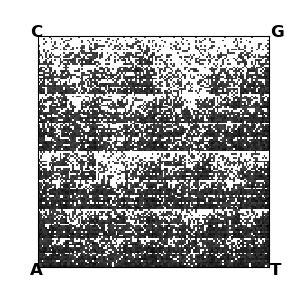

In [5]:
plt.figure(figsize=(3,3))
plt.imshow(cgr_mats[-1]**0.1, cmap='gray_r', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.text(-5, 0, 'C', fontsize=12, fontweight='bold')
plt.text(128, 0, 'G', fontsize=12, fontweight='bold')
plt.text(128, 132, 'T', fontsize=12, fontweight='bold')
plt.text(-5, 132, 'A', fontsize=12, fontweight='bold')
plt.show()
# C G #
# A T #

### Plot CGRs

In [6]:
"""
n_rows, m_cols = 83, 11
length = len(cgr_mats)
binary_cgr_mats = np.where(np.array(cgr_mats) != 0, 1, 0)
fig, ax = plt.subplots(n_rows,m_cols, figsize=(4*m_cols, 4*n_rows))
ax = ax.flatten() # instead of a nested for loop
for i in range(length):
    ax[i].imshow(binary_cgr_mats[i], aspect='auto', cmap='gray_r', interpolation='nearest')
    ax[i].axis('off')
plt.tight_layout()""";

In [7]:
"""
n_rows, m_cols = 1, 1
length = len(cgr_mats)
binary_cgr_mats = np.where(np.array(cgr_mats) != 0, 1, 0)
fig, ax = plt.subplots(n_rows,m_cols, figsize=(2*m_cols, 2*n_rows))
for i in range(length):
    ax.imshow(binary_cgr_mats[i], aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.axis('off')
    if i < len(sequences_delta):
        plt.savefig(f'./plots/delta_{i+1}.png',  bbox_inches='tight', pad_inches=0, dpi=64)
    else:
        j = i-len(sequences_delta)
        plt.savefig(f'./plots/omicron_{j+1}.png', bbox_inches='tight', dpi=64, pad_inches=0)
    plt.cla();
plt.clf();""";

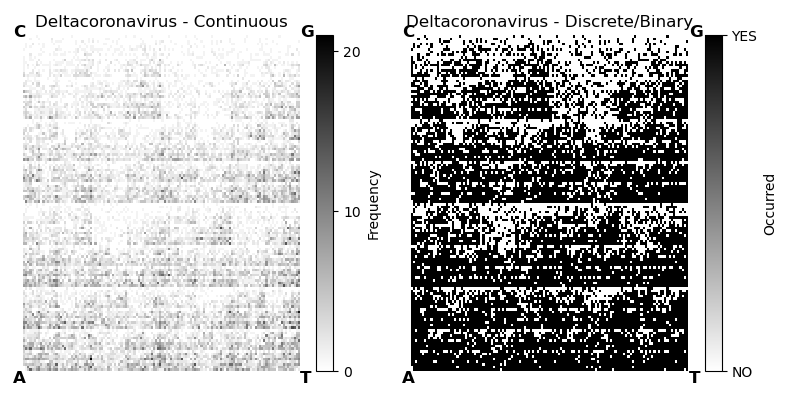

In [8]:
n_rows, m_cols = 1, 2
fig, ax = plt.subplots(n_rows,m_cols, figsize=(4*m_cols, 4*n_rows))
ax = ax.flatten() # instead of a nested for loop
im1 = ax[0].imshow(cgr_mats[0], aspect='auto', cmap='gray_r', interpolation='none')
ax[0].axis('off')
ax[0].set_title('Deltacoronavirus - Continuous')
cbarr = fig.colorbar(im1, ax=ax[0])
cbarr.set_label('Frequency')
cbarr.set_ticks([0,10,20])


cgr_mats_binary = np.where(np.array(cgr_mats) != 0, 1, 0)
im2 = ax[1].imshow(cgr_mats_binary[0], aspect='auto', cmap='gray_r', interpolation='none')
ax[1].axis('off')
ax[1].set_title('Deltacoronavirus - Discrete/Binary')
cbar = fig.colorbar(im2, ax=ax[1])
cbar.set_ticks([0,1])
cbar.set_ticklabels(['NO', 'YES'])
cbar.set_label('Occurred')

ax[0].text(-5, 0, 'C', fontsize=12, fontweight='bold')
ax[0].text(128, 0, 'G', fontsize=12, fontweight='bold')
ax[0].text(128, 132, 'T', fontsize=12, fontweight='bold')
ax[0].text(-5, 132, 'A', fontsize=12, fontweight='bold')
ax[1].text(-5, 0, 'C', fontsize=12, fontweight='bold')
ax[1].text(128, 0, 'G', fontsize=12, fontweight='bold')
ax[1].text(128, 132, 'T', fontsize=12, fontweight='bold')
ax[1].text(-5, 132, 'A', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
combined_arrays = np.concatenate([cgrs['Delta'], cgrs['Omicron']])
D = pairwise_distances(combined_arrays, metric='manhattan')

In [10]:
D.shape[0] == len(sequences_delta) + len(sequences_omicron)

True

#### Diagonal D(a,a) = 0 check

In [11]:
np.all(np.diag(D) == 0)

True

#### Symmetry D(a,b) = D(b,a) check

In [12]:
np.all(D == D.T)

True

## MDS - Multidimensional Scaling

In [13]:
reduced = perform_mds(D, 3)
embeddings = {'Delta':[reduced[:len(sequences_delta), _] for _ in range(len(reduced.T))],
              'Omicron':[reduced[len(sequences_delta):, _] for _ in range(len(reduced.T))]}

## Visualization 

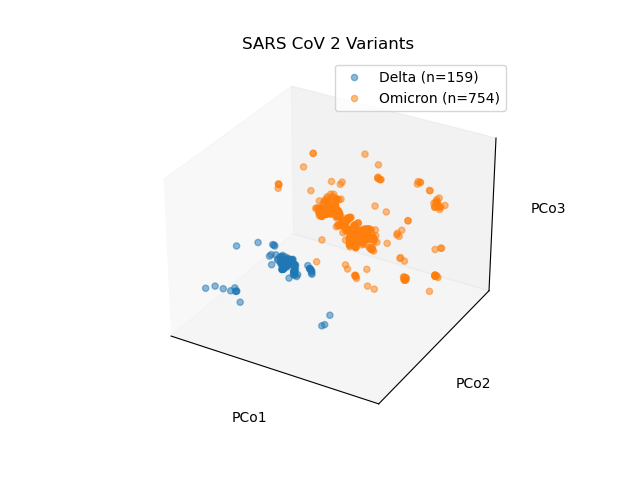

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings['Delta'][0], embeddings['Delta'][1],embeddings['Delta'][2],alpha=0.5, label=f"Delta (n={len(embeddings['Delta'][0])})")
ax.scatter(embeddings['Omicron'][0],embeddings['Omicron'][1],embeddings['Omicron'][2],alpha=0.5, label=f"Omicron (n={len(embeddings['Omicron'][0])})")
ax.set_xlabel('PCo1')
ax.set_ylabel('PCo2')
ax.set_zlabel('PCo3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title('SARS CoV 2 Variants')
ax.legend()
plt.show()